In [74]:
import json
import matplotlib.pyplot as plt
import os
import sys
import typing
from collections import defaultdict
import numpy as np
import pandas as pd
from pathlib import Path

from Bio import SeqIO
 

In [2]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [3]:
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

In [5]:
def run_single_method_for_orf_sequence(optimization_method: str,
                                       is_ecoli_optimized: bool,
                                       orf_sequence: typing.Optional[str] = None,
                                       orf_sequence_file: typing.Optional[str] = None,
                                       output_path: typing.Optional[str] = None,
                                       optimization_cub_index: str = "CAI"):
    default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
        optimization_method=optimization_method,
        optimization_cub_index=optimization_cub_index,
        clusters_count=1,
        tuning_param=0.5,
        is_ecoli_optimized=is_ecoli_optimized,
        sequence=orf_sequence,
        sequence_file_path=orf_sequence_file,
        output_path=os.path.join("results", output_path),
    )
    return run_modules(default_user_inp_raw)

In [6]:
def run_all_methods(orf_sequence = None, orf_sequence_file = None, output_path = None):
    for optimization_method in [
        "single_codon_ratio",
        "single_codon_diff",
        "single_codon_weakest_link",
        # "zscore_single_aa_ratio",
        "zscore_bulk_aa_ratio",
        # "zscore_single_aa_diff",
        "zscore_bulk_aa_diff",
        # "zscore_single_aa_weakest_link",
        "zscore_bulk_aa_weakest_link",
    ]:
        for optimization_cub_index in ["CAI", "tAI"]:
            for direction in [True, False]:
                run_single_method_for_orf_sequence(optimization_method=optimization_method,
                                                   optimization_cub_index=optimization_cub_index,
                                                   is_ecoli_optimized=direction,
                                                   orf_sequence=orf_sequence,
                                                   orf_sequence_file=orf_sequence_file,
                                                   output_path=output_path)

In [5]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")

## Generating mcherry variants

In [6]:
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry")

In [9]:
def generate_sequences_fasta_file(root_dir) -> None:
    filename = "run_summary.json"

    sequences = []
    sequences_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)

                seq = results_json["evaluation"]["final_sequence"]
                sequences.append(seq)
                sequences_names.append(directory_name[:-5])

    shared_functions_and_vars.write_fasta(os.path.join(root_dir, "mcherry_variants"), sequences, sequences_names)

In [17]:
mcherry_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry"
mcherry_variants_file = os.path.join(mcherry_root_dir, "mcherry_variants.fasta")

In [ ]:
generate_sequences_fasta_file(mcherry_root_dir)

## Verification of variants translation to correct amino acid sequence

In [19]:
# Reference aa sequence is taken from: https://www.addgene.org/browse/sequence_vdb/6496/
reference_mcherry_protein_seq = "MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK*"
formatted_reference_mcherry_protein_seq = reference_mcherry_protein_seq.replace("*", "_")

Validating original mcherry sequence:

In [14]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = list(mcherry_dict.values())[0].seq
translated_original_mcherry_seq = shared_functions_and_vars.translate(original_mcherry_seq)

assert translated_original_mcherry_seq == formatted_reference_mcherry_protein_seq

Validating generated mcherry variants:

In [23]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

for variant_name, variant_seq in mcherry_variants_dict.items():
    translated_seq = shared_functions_and_vars.translate(variant_seq.seq)
    if translated_seq != formatted_reference_mcherry_protein_seq:
        raise ValueError(f"Variant {variant_name} is not coding to correct sequence. \nReference sequence: {formatted_reference_mcherry_protein_seq} \nVariant sequence: {translated_seq}")

## Calculating codon frequencies 

In [38]:
bacillus_endogenous_genes_fasta_file_path = r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis.fasta"
ecoli_endogenous_genes_fasta_file_path =  r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli.fasta"

In [75]:
def calculate_codon_frequencies(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies

    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        total_amino_acid_codons = 0
        for amino_acid_codon in codons:
            total_amino_acid_codons += codons_counter[amino_acid_codon]
        
        # In case a certain amino acid is missing from the reference cds collection, no need to normalize
        if total_amino_acid_codons == 0:
            continue
        
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] /= total_amino_acid_codons
    
    df_dict = {"codon": list(codons_counter.keys()), "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons_counter.keys()], "frequency": list(codons_counter.values())}
    return pd.DataFrame(df_dict)

In [76]:
def plot_frequency_map(frequency_df):
    sorted_df = frequency_df.sort_values("amino_acid")
    
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.rcParams["figure.autolayout"] = True

    sorted_df.plot("codon", "frequency", kind="bar", color = "b")

In [77]:
def calculate_distance_between_frequencies(first_codons_freq, second_codons_freq):
    return np.linalg.norm(first_codons_freq-second_codons_freq)

In [135]:
with open(bacillus_endogenous_genes_fasta_file_path, "r") as bacillus_endogenous_genes_fasta_file:
    bacillus_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(bacillus_endogenous_genes_fasta_file, "fasta"))

bacillus_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies = bacillus_codon_frequencies.sort_values("codon")

with open(ecoli_endogenous_genes_fasta_file_path, "r") as ecoli_endogenous_genes_fasta_file:
    ecoli_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(ecoli_endogenous_genes_fasta_file, "fasta"))

ecoli_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies = ecoli_codon_frequencies.sort_values("codon")

In [136]:
original_mcherry_codon_frequencies = calculate_codon_frequencies((str(original_mcherry_seq),))
original_mcherry_codon_frequencies = original_mcherry_codon_frequencies.sort_values("codon")

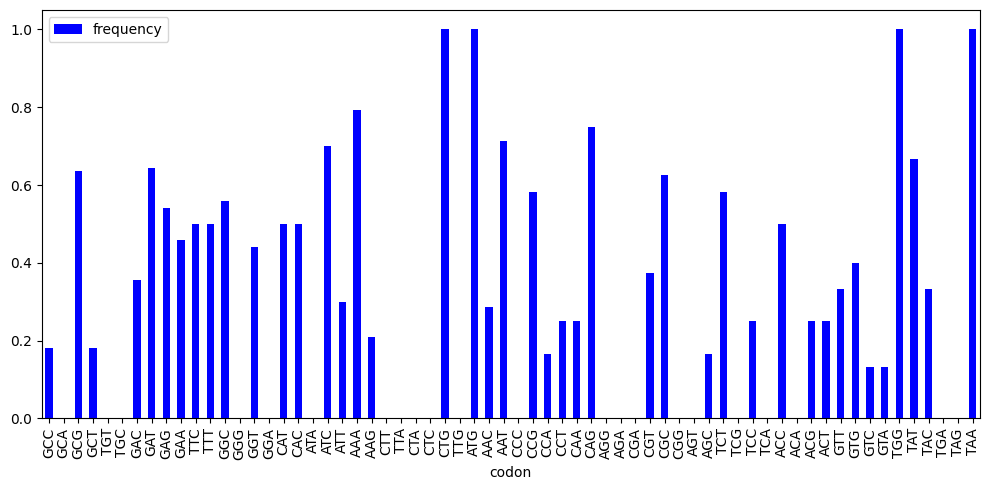

In [142]:
plot_frequency_map(original_mcherry_codon_frequencies)

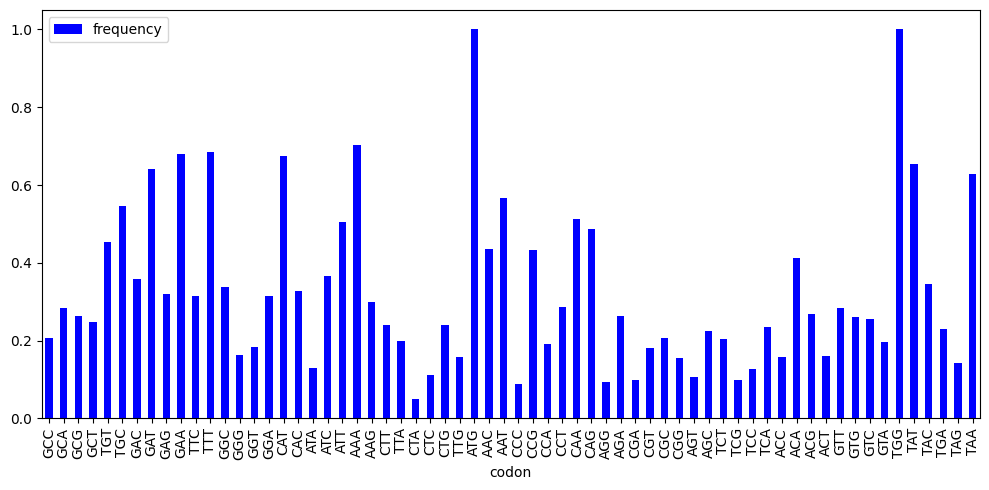

In [143]:
plot_frequency_map(bacillus_codon_frequencies)

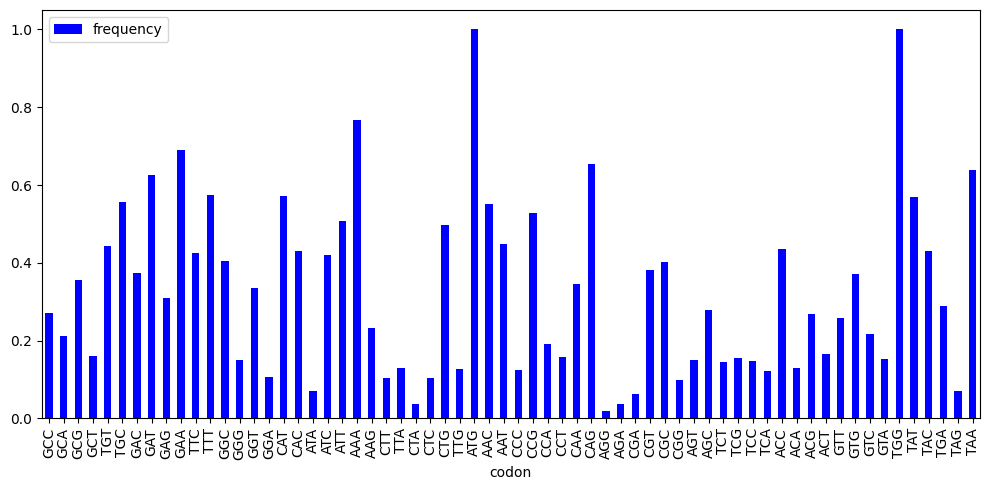

In [144]:
plot_frequency_map(ecoli_codon_frequencies)

In [174]:
original_bacillus_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_codon_frequencies["frequency"].reset_index(drop=True))

In [175]:
original_ecoli_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_codon_frequencies["frequency"].reset_index(drop=True))

In [176]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))


df_dict = {"variant": ["original_mcherry"], "ecoli_dist": [original_ecoli_dist], "bacillus_dist": [original_bacillus_dist]}    
for variant_name, variant_seq in mcherry_variants_dict.items():
    mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
    df_dict["variant"].append(variant_name)
    
    series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
    series2 =  ecoli_codon_frequencies["frequency"].reset_index(drop=True)
    series3 =  bacillus_codon_frequencies["frequency"].reset_index(drop=True)
    df_dict["ecoli_dist"].append(calculate_distance_between_frequencies(series1, series2))
    df_dict["bacillus_dist"].append(calculate_distance_between_frequencies(series1, series3))    

variants_dataframe = pd.DataFrame(df_dict)
variants_dataframe

,variant,ecoli_dist,bacillus_dist
0,original_mcherry,1.442503,1.849371
1,CAI_single_codon_diff_ecoli_opt_False,4.126050,3.553950
2,CAI_single_codon_diff_ecoli_opt_True,3.665441,3.942362
3,CAI_single_codon_ratio_ecoli_opt_False,3.176776,2.952852
4,CAI_single_codon_ratio_ecoli_opt_True,2.884517,3.412751
5,CAI_single_codon_weakest_link_ecoli_opt_False,4.126050,3.553950
6,CAI_single_codon_weakest_link_ecoli_opt_True,3.665441,3.942362
7,CAI_zscore_bulk_aa_diff_ecoli_opt_False,3.517246,2.927731
8,CAI_zscore_bulk_aa_diff_ecoli_opt_True,3.663026,4.046293
9,CAI_zscore_bulk_aa_ratio_ecoli_opt_False,3.531985,2.939781


<AxesSubplot:xlabel='variant'>

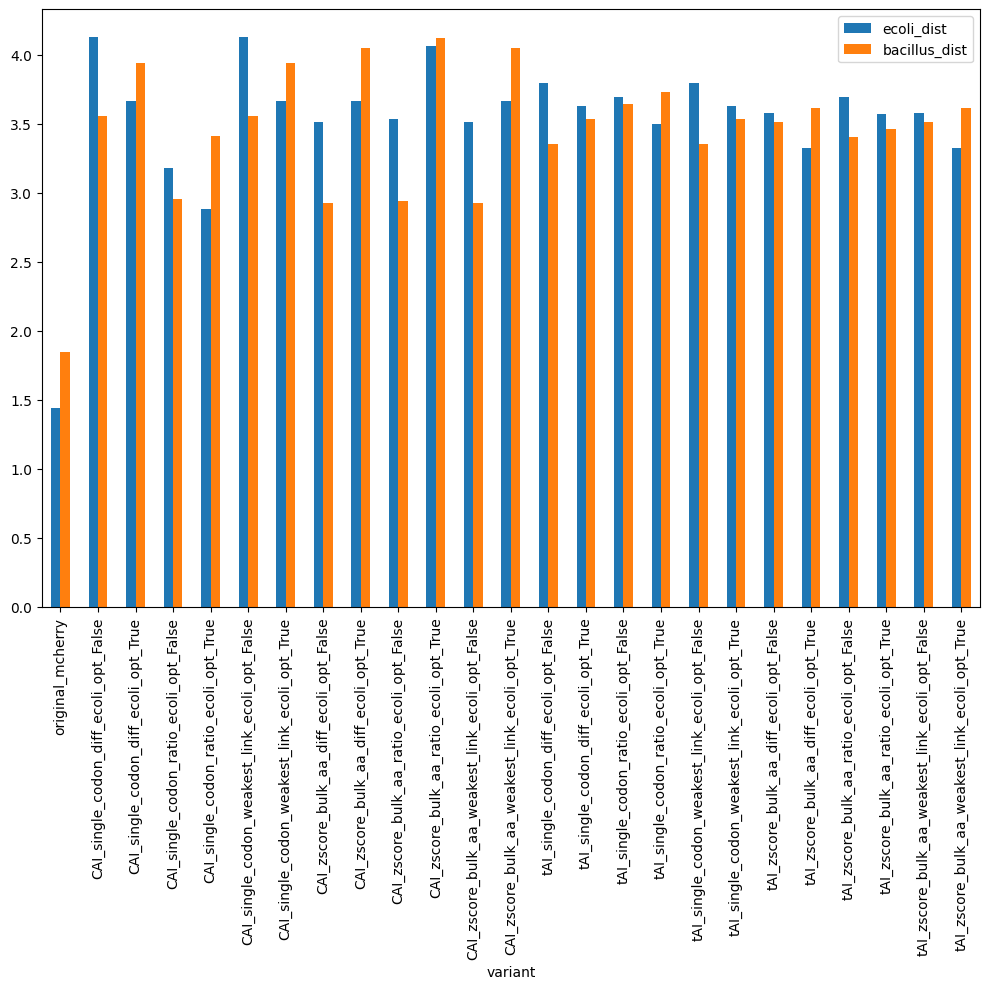

In [177]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
variants_dataframe.plot("variant", kind="bar")